# Exploratory Data Analysis: Bloom's Taxonomy for IIIT Courses

This notebook performs comprehensive EDA on the Bloom's Taxonomy classifications for learning objectives across all IIIT courses.

In [6]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Load the data
with open('../datasets/iiit_taxonomy_blooms.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

print(f"Total Courses: {len(data)}")
print(f"Sample Course: {data[0]['Course Title']}")

Total Courses: 115
Sample Course: Advanced Computer Architecture


## 1. Data Preparation and Extraction

In [7]:
# Extract all learning objectives with their Bloom's taxonomy levels
all_los = []

for course in data:
    course_title = course['Course Title']
    if 'LO_Analysis' in course and course['LO_Analysis']:
        for lo in course['LO_Analysis']:
            if 'blooms_taxonomy' in lo and lo['blooms_taxonomy']:
                all_los.append({
                    'course': course_title,
                    'lo': lo.get('original_lo', ''),
                    'level': lo['blooms_taxonomy'].get('level', 'Unknown'),
                    'justification': lo['blooms_taxonomy'].get('justification', '')
                })

# Create DataFrame
df = pd.DataFrame(all_los)
print(f"Total Learning Objectives: {len(df)}")
print(f"Courses with LOs: {df['course'].nunique()}")
print(f"\nBloom's Levels Found:")
print(df['level'].value_counts())

Total Learning Objectives: 633
Courses with LOs: 115

Bloom's Levels Found:
level
Understand    228
Apply         196
Analyze        84
Create         70
Evaluate       35
Remember       20
Name: count, dtype: int64


## 2. Overall Distribution of Bloom's Taxonomy Levels

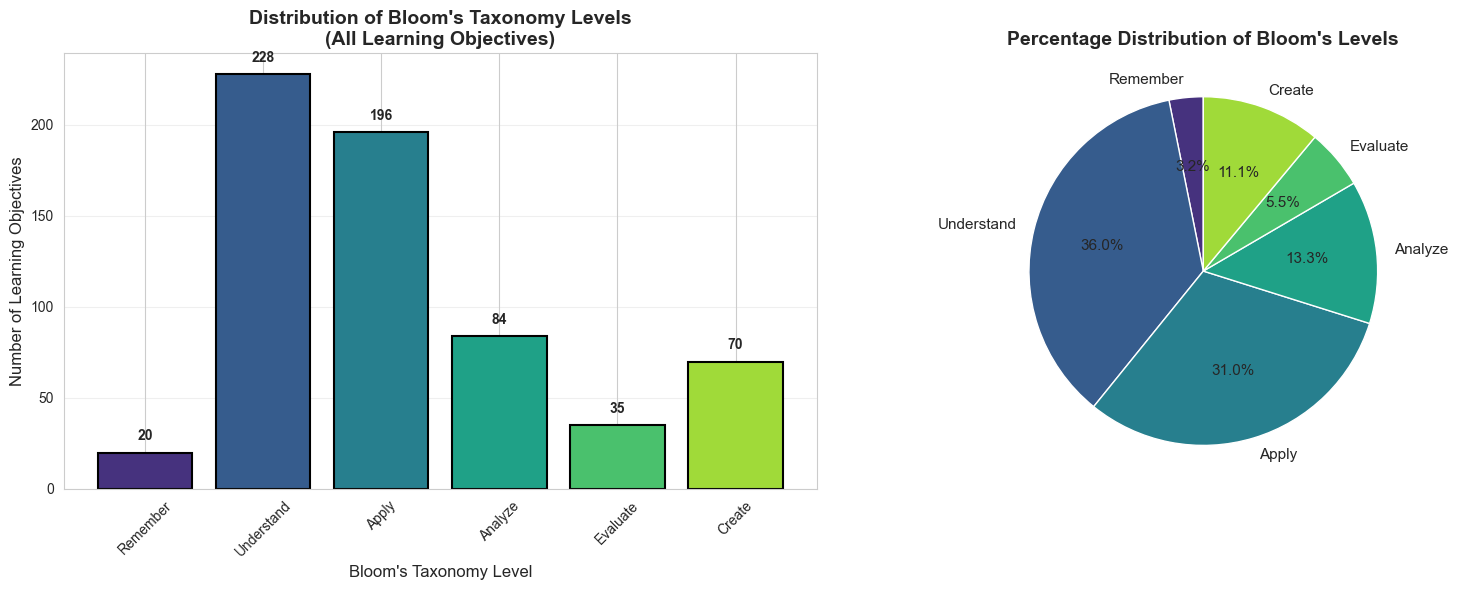


📊 Summary Statistics:
Total LOs: 633
Most Common Level: Understand (228 occurrences)
Least Common Level: Remember (20 occurrences)


In [8]:
# Define Bloom's taxonomy order (from lower to higher cognitive levels)
bloom_order = ['Remember', 'Understand', 'Apply', 'Analyze', 'Evaluate', 'Create']

# Count occurrences
level_counts = df['level'].value_counts()

# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot
colors = sns.color_palette("viridis", len(bloom_order))
sorted_counts = [level_counts.get(level, 0) for level in bloom_order]
axes[0].bar(bloom_order, sorted_counts, color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_title('Distribution of Bloom\'s Taxonomy Levels\n(All Learning Objectives)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Bloom\'s Taxonomy Level', fontsize=12)
axes[0].set_ylabel('Number of Learning Objectives', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(sorted_counts):
    axes[0].text(i, v + 5, str(v), ha='center', va='bottom', fontsize=10, fontweight='bold')

# Pie chart
axes[1].pie(sorted_counts, labels=bloom_order, autopct='%1.1f%%', startangle=90, 
            colors=colors, textprops={'fontsize': 11})
axes[1].set_title('Percentage Distribution of Bloom\'s Levels', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Print statistics
print("\n📊 Summary Statistics:")
print(f"Total LOs: {len(df)}")
print(f"Most Common Level: {level_counts.index[0]} ({level_counts.iloc[0]} occurrences)")
print(f"Least Common Level: {level_counts.index[-1]} ({level_counts.iloc[-1]} occurrences)")

## 3. Bloom's Levels per Course - Aggregate Analysis

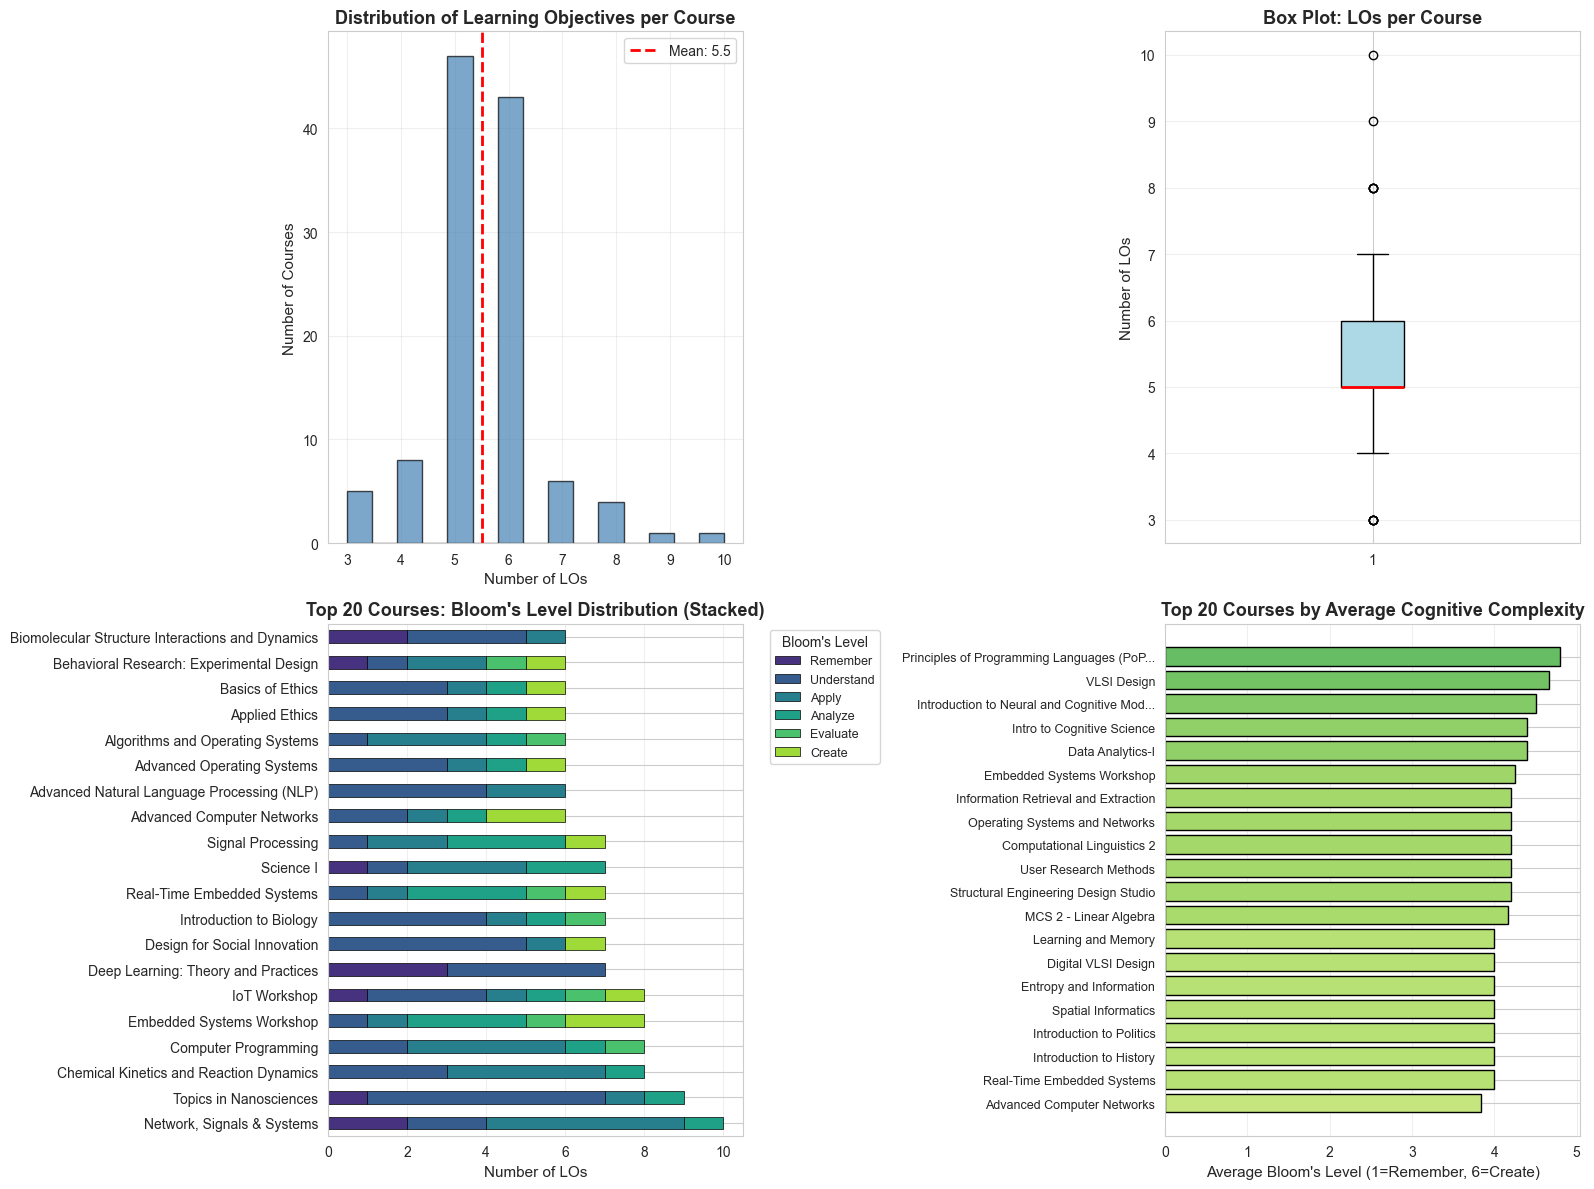


📈 Course-Level Statistics:
Average LOs per course: 5.50
Median LOs per course: 5
Max LOs in a course: 10 (Network, Signals & Systems)
Min LOs in a course: 3 (Bioinformatics)


In [9]:
# Average number of LOs per course
los_per_course = df.groupby('course').size()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribution of LOs per course
axes[0, 0].hist(los_per_course, bins=15, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Learning Objectives per Course', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Number of LOs', fontsize=11)
axes[0, 0].set_ylabel('Number of Courses', fontsize=11)
axes[0, 0].axvline(los_per_course.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {los_per_course.mean():.1f}')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Box plot of LOs per course
axes[0, 1].boxplot(los_per_course, vert=True, patch_artist=True, 
                    boxprops=dict(facecolor='lightblue', color='black'),
                    medianprops=dict(color='red', linewidth=2))
axes[0, 1].set_title('Box Plot: LOs per Course', fontsize=13, fontweight='bold')
axes[0, 1].set_ylabel('Number of LOs', fontsize=11)
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Bloom's level distribution by course (stacked bar for top 20 courses)
course_bloom_counts = df.groupby(['course', 'level']).size().unstack(fill_value=0)
course_bloom_counts = course_bloom_counts.reindex(columns=bloom_order, fill_value=0)
top_20_courses = los_per_course.nlargest(20).index
course_bloom_top20 = course_bloom_counts.loc[top_20_courses]

course_bloom_top20.plot(kind='barh', stacked=True, ax=axes[1, 0], 
                         color=colors, edgecolor='black', linewidth=0.5)
axes[1, 0].set_title('Top 20 Courses: Bloom\'s Level Distribution (Stacked)', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Number of LOs', fontsize=11)
axes[1, 0].set_ylabel('')
axes[1, 0].legend(title='Bloom\'s Level', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[1, 0].grid(axis='x', alpha=0.3)

# 4. Average Bloom's level complexity per course
# Assign numeric values to levels (higher = more complex)
level_complexity = {level: i for i, level in enumerate(bloom_order, 1)}
df['complexity'] = df['level'].map(level_complexity)
course_complexity = df.groupby('course')['complexity'].mean().sort_values(ascending=False).head(20)

axes[1, 1].barh(range(len(course_complexity)), course_complexity.values, 
                color=plt.cm.RdYlGn(course_complexity.values / 6), edgecolor='black')
axes[1, 1].set_yticks(range(len(course_complexity)))
axes[1, 1].set_yticklabels([c[:40] + '...' if len(c) > 40 else c for c in course_complexity.index], fontsize=9)
axes[1, 1].set_title('Top 20 Courses by Average Cognitive Complexity', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Average Bloom\'s Level (1=Remember, 6=Create)', fontsize=11)
axes[1, 1].grid(axis='x', alpha=0.3)
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

print(f"\n📈 Course-Level Statistics:")
print(f"Average LOs per course: {los_per_course.mean():.2f}")
print(f"Median LOs per course: {los_per_course.median():.0f}")
print(f"Max LOs in a course: {los_per_course.max()} ({los_per_course.idxmax()})")
print(f"Min LOs in a course: {los_per_course.min()} ({los_per_course.idxmin()})")

## 4. Heatmap: Course vs Bloom's Level

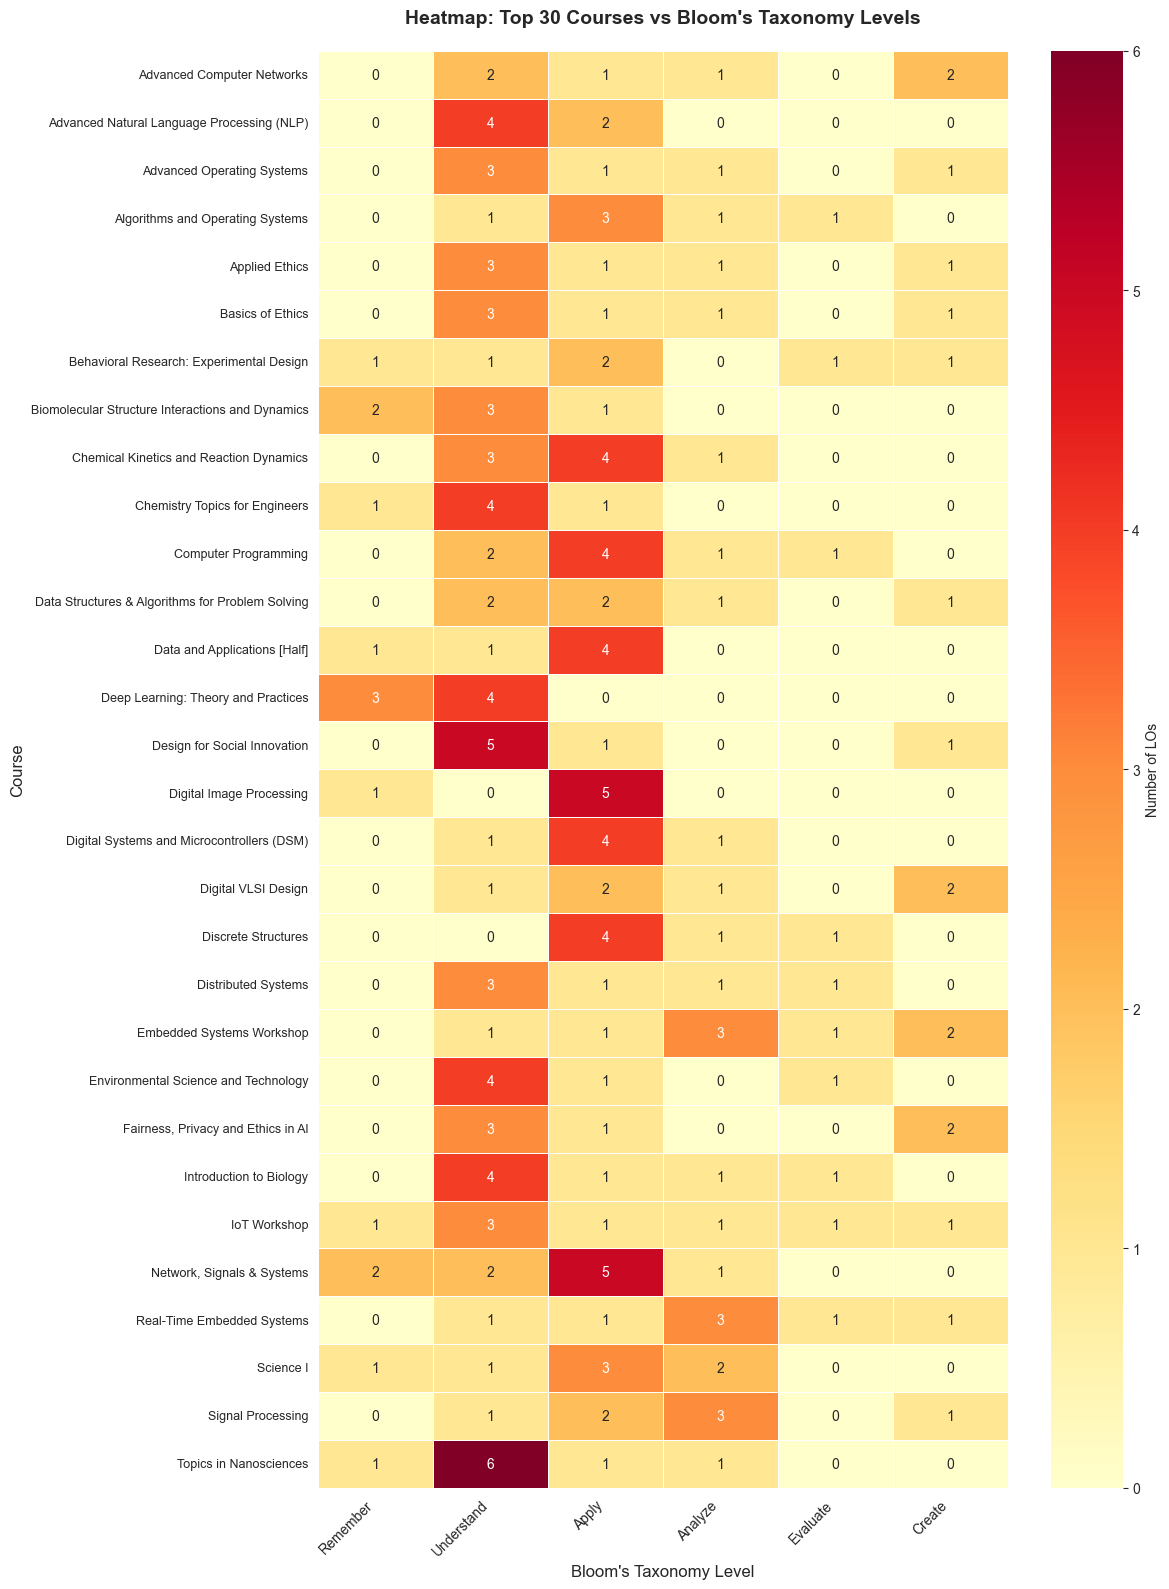

In [10]:
# Select top 30 courses by total LOs for readability
top_30_courses = los_per_course.nlargest(30).index
course_bloom_matrix = df[df['course'].isin(top_30_courses)].groupby(['course', 'level']).size().unstack(fill_value=0)
course_bloom_matrix = course_bloom_matrix.reindex(columns=bloom_order, fill_value=0)

plt.figure(figsize=(12, 16))
sns.heatmap(course_bloom_matrix, annot=True, fmt='d', cmap='YlOrRd', 
            linewidths=0.5, cbar_kws={'label': 'Number of LOs'})
plt.title('Heatmap: Top 30 Courses vs Bloom\'s Taxonomy Levels', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Bloom\'s Taxonomy Level', fontsize=12)
plt.ylabel('Course', fontsize=12)
plt.yticks(rotation=0, fontsize=9)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 5. Cognitive Level Progression Analysis

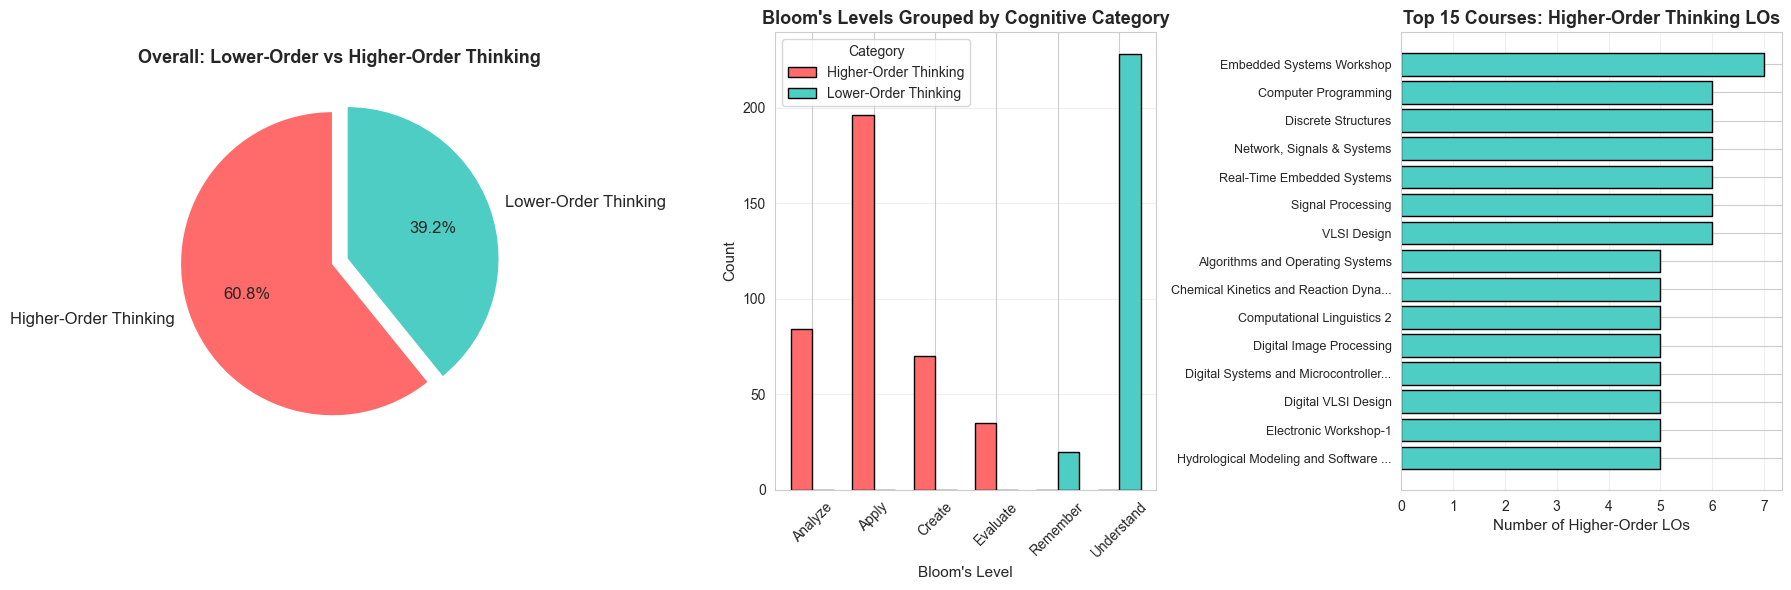


🧠 Cognitive Category Analysis:
Lower-Order Thinking LOs: 248 (39.2%)
Higher-Order Thinking LOs: 385 (60.8%)


In [11]:
# Categorize levels into Lower-Order (Remember, Understand) and Higher-Order (Apply, Analyze, Evaluate, Create)
lower_order = ['Remember', 'Understand']
higher_order = ['Apply', 'Analyze', 'Evaluate', 'Create']

df['cognitive_category'] = df['level'].apply(
    lambda x: 'Lower-Order Thinking' if x in lower_order else 'Higher-Order Thinking'
)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Overall Lower vs Higher Order
category_counts = df['cognitive_category'].value_counts()
colors_cat = ['#FF6B6B', '#4ECDC4']
axes[0].pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', 
            startangle=90, colors=colors_cat, textprops={'fontsize': 12}, explode=(0.05, 0.05))
axes[0].set_title('Overall: Lower-Order vs Higher-Order Thinking', fontsize=13, fontweight='bold')

# 2. Distribution by level grouped by category
level_by_category = df.groupby(['cognitive_category', 'level']).size().unstack(fill_value=0)
level_by_category.T.plot(kind='bar', ax=axes[1], color=['#FF6B6B', '#4ECDC4'], 
                          edgecolor='black', width=0.7)
axes[1].set_title('Bloom\'s Levels Grouped by Cognitive Category', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Bloom\'s Level', fontsize=11)
axes[1].set_ylabel('Count', fontsize=11)
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Category', fontsize=10)
axes[1].grid(axis='y', alpha=0.3)

# 3. Courses with most higher-order thinking
course_hot = df[df['cognitive_category'] == 'Higher-Order Thinking'].groupby('course').size()
top_hot_courses = course_hot.nlargest(15)

axes[2].barh(range(len(top_hot_courses)), top_hot_courses.values, 
             color='#4ECDC4', edgecolor='black')
axes[2].set_yticks(range(len(top_hot_courses)))
axes[2].set_yticklabels([c[:35] + '...' if len(c) > 35 else c for c in top_hot_courses.index], fontsize=9)
axes[2].set_title('Top 15 Courses: Higher-Order Thinking LOs', fontsize=13, fontweight='bold')
axes[2].set_xlabel('Number of Higher-Order LOs', fontsize=11)
axes[2].grid(axis='x', alpha=0.3)
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

print(f"\n🧠 Cognitive Category Analysis:")
print(f"Lower-Order Thinking LOs: {category_counts.get('Lower-Order Thinking', 0)} ({category_counts.get('Lower-Order Thinking', 0)/len(df)*100:.1f}%)")
print(f"Higher-Order Thinking LOs: {category_counts.get('Higher-Order Thinking', 0)} ({category_counts.get('Higher-Order Thinking', 0)/len(df)*100:.1f}%)")

## 6. Word Cloud Analysis from Justifications

In [12]:
try:
    from wordcloud import WordCloud
    
    # Combine all justifications for each Bloom's level
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for idx, level in enumerate(bloom_order):
        justifications = ' '.join(df[df['level'] == level]['justification'].dropna().tolist())
        
        if justifications.strip():
            wordcloud = WordCloud(width=800, height=400, background_color='white',
                                  colormap='viridis', max_words=50).generate(justifications)
            
            axes[idx].imshow(wordcloud, interpolation='bilinear')
            axes[idx].set_title(f'{level} - Common Words', fontsize=13, fontweight='bold')
            axes[idx].axis('off')
        else:
            axes[idx].text(0.5, 0.5, f'No data for {level}', ha='center', va='center', fontsize=12)
            axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
except ImportError:
    print("⚠️ WordCloud library not installed. Install with: pip install wordcloud")
    print("Skipping word cloud visualization...")

⚠️ WordCloud library not installed. Install with: pip install wordcloud
Skipping word cloud visualization...


## 7. Top Courses Analysis by Department/Field

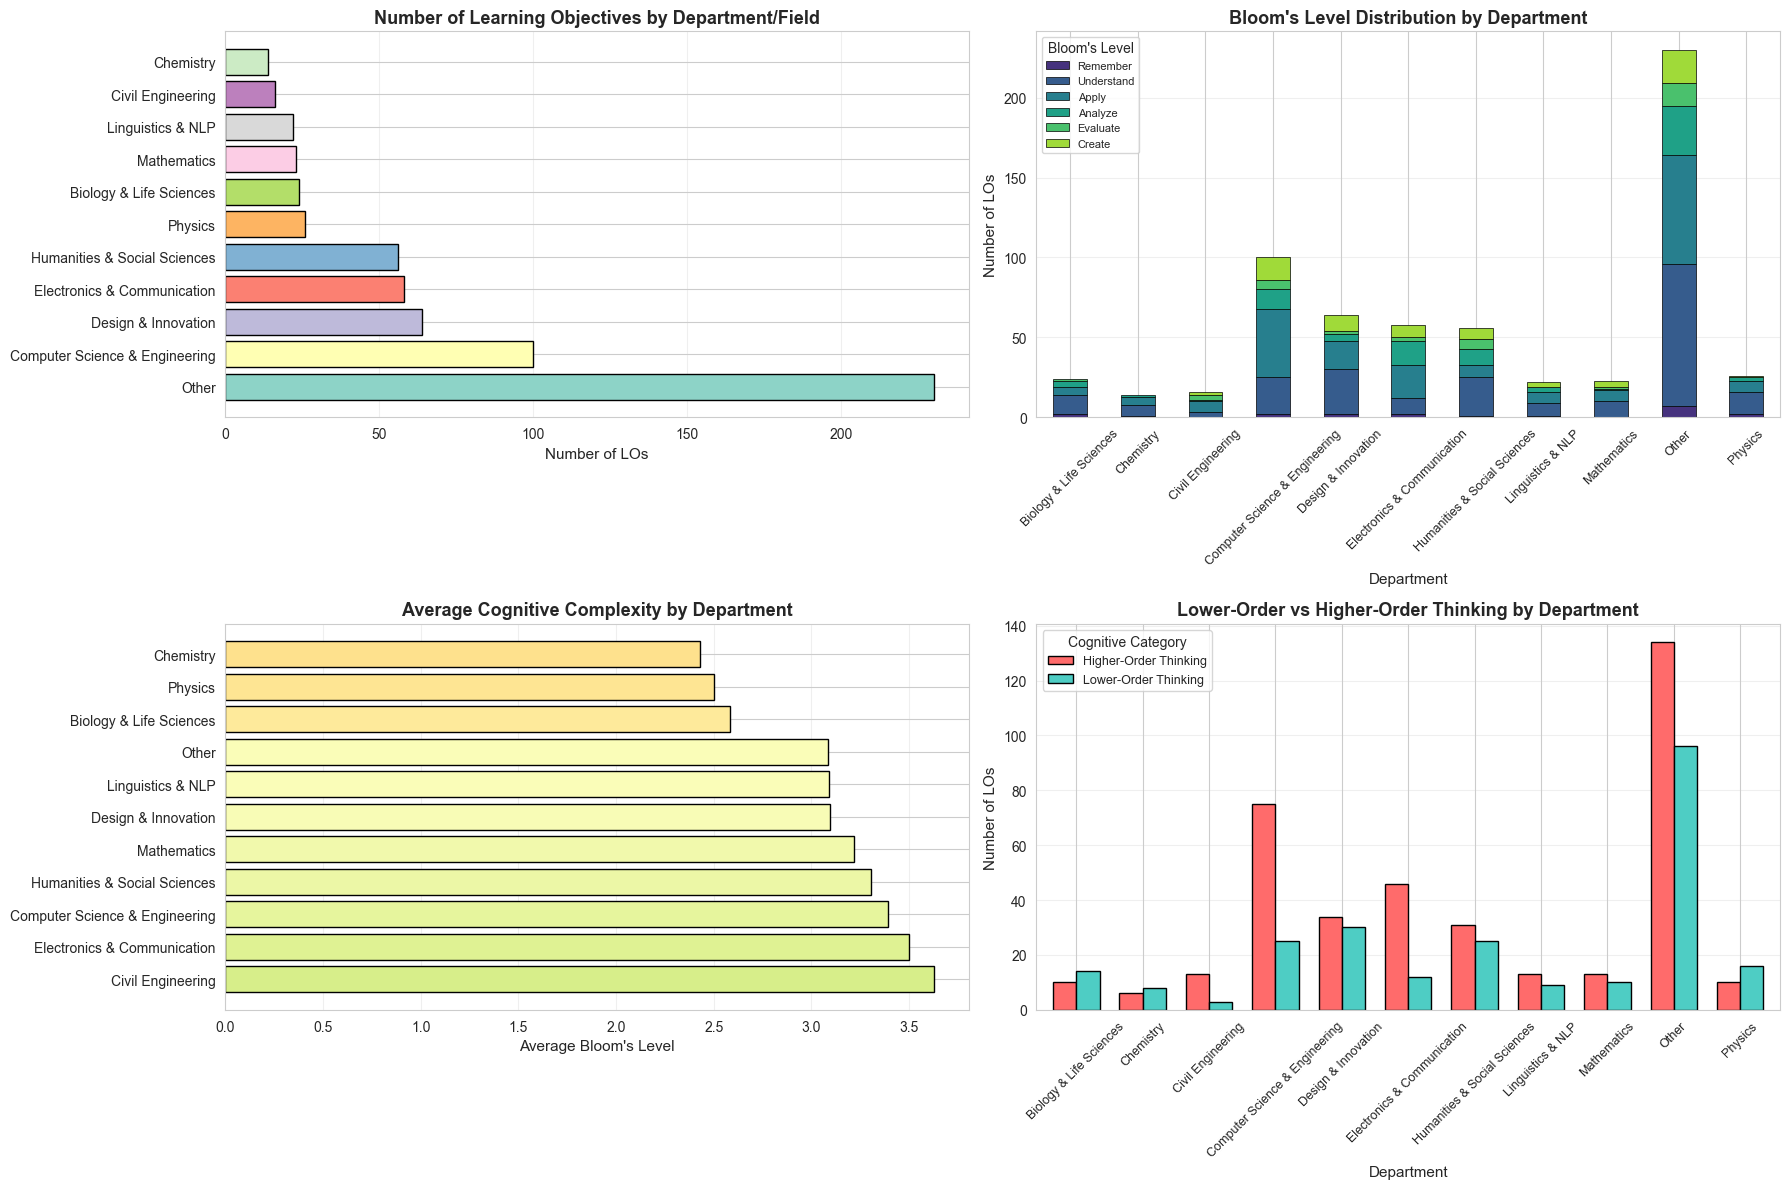


🏫 Department Statistics:
Other: 230 LOs, Avg Complexity: 3.08
Computer Science & Engineering: 100 LOs, Avg Complexity: 3.39
Design & Innovation: 64 LOs, Avg Complexity: 3.09
Electronics & Communication: 58 LOs, Avg Complexity: 3.50
Humanities & Social Sciences: 56 LOs, Avg Complexity: 3.30
Physics: 26 LOs, Avg Complexity: 2.50
Biology & Life Sciences: 24 LOs, Avg Complexity: 2.58
Mathematics: 23 LOs, Avg Complexity: 3.22
Linguistics & NLP: 22 LOs, Avg Complexity: 3.09
Civil Engineering: 16 LOs, Avg Complexity: 3.62
Chemistry: 14 LOs, Avg Complexity: 2.43


In [13]:
# Extract department/field from course title keywords
def categorize_course(title):
    title_lower = title.lower()
    if any(word in title_lower for word in ['computer', 'algorithm', 'data', 'software', 'programming', 'vlsi', 'digital']):
        return 'Computer Science & Engineering'
    elif any(word in title_lower for word in ['physics', 'quantum', 'mechanics']):
        return 'Physics'
    elif any(word in title_lower for word in ['biology', 'bio', 'molecular']):
        return 'Biology & Life Sciences'
    elif any(word in title_lower for word in ['math', 'algebra', 'statistics', 'probability', 'calculus']):
        return 'Mathematics'
    elif any(word in title_lower for word in ['electronic', 'signal', 'circuit', 'embedded', 'network']):
        return 'Electronics & Communication'
    elif any(word in title_lower for word in ['design', 'thinking', 'innovation', 'product']):
        return 'Design & Innovation'
    elif any(word in title_lower for word in ['ethics', 'philosophy', 'society', 'psychology', 'economics', 'politics', 'history']):
        return 'Humanities & Social Sciences'
    elif any(word in title_lower for word in ['linguistic', 'language', 'speech', 'nlp']):
        return 'Linguistics & NLP'
    elif any(word in title_lower for word in ['earthquake', 'structural', 'civil', 'infrastructure']):
        return 'Civil Engineering'
    elif any(word in title_lower for word in ['chemistry', 'chemical']):
        return 'Chemistry'
    else:
        return 'Other'

df['department'] = df['course'].apply(categorize_course)

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Courses per department
dept_counts = df['department'].value_counts()
axes[0, 0].barh(dept_counts.index, dept_counts.values, color=sns.color_palette("Set3", len(dept_counts)), edgecolor='black')
axes[0, 0].set_title('Number of Learning Objectives by Department/Field', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Number of LOs', fontsize=11)
axes[0, 0].grid(axis='x', alpha=0.3)

# 2. Bloom's level distribution by department
dept_bloom = df.groupby(['department', 'level']).size().unstack(fill_value=0)
dept_bloom = dept_bloom.reindex(columns=bloom_order, fill_value=0)
dept_bloom.plot(kind='bar', stacked=True, ax=axes[0, 1], color=colors, edgecolor='black', linewidth=0.5)
axes[0, 1].set_title('Bloom\'s Level Distribution by Department', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Department', fontsize=11)
axes[0, 1].set_ylabel('Number of LOs', fontsize=11)
axes[0, 1].tick_params(axis='x', rotation=45, labelsize=9)
axes[0, 1].legend(title='Bloom\'s Level', fontsize=8)
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Average complexity by department
dept_complexity = df.groupby('department')['complexity'].mean().sort_values(ascending=False)
axes[1, 0].barh(dept_complexity.index, dept_complexity.values, 
                color=plt.cm.RdYlGn(dept_complexity.values / 6), edgecolor='black')
axes[1, 0].set_title('Average Cognitive Complexity by Department', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Average Bloom\'s Level', fontsize=11)
axes[1, 0].grid(axis='x', alpha=0.3)

# 4. Higher-order vs Lower-order by department
dept_cognitive = df.groupby(['department', 'cognitive_category']).size().unstack(fill_value=0)
dept_cognitive.plot(kind='bar', ax=axes[1, 1], color=['#FF6B6B', '#4ECDC4'], edgecolor='black', width=0.7)
axes[1, 1].set_title('Lower-Order vs Higher-Order Thinking by Department', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Department', fontsize=11)
axes[1, 1].set_ylabel('Number of LOs', fontsize=11)
axes[1, 1].tick_params(axis='x', rotation=45, labelsize=9)
axes[1, 1].legend(title='Cognitive Category', fontsize=9)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🏫 Department Statistics:")
for dept in dept_counts.index:
    total = dept_counts[dept]
    avg_complexity = dept_complexity[dept]
    print(f"{dept}: {total} LOs, Avg Complexity: {avg_complexity:.2f}")

## 8. Statistical Summary and Key Insights

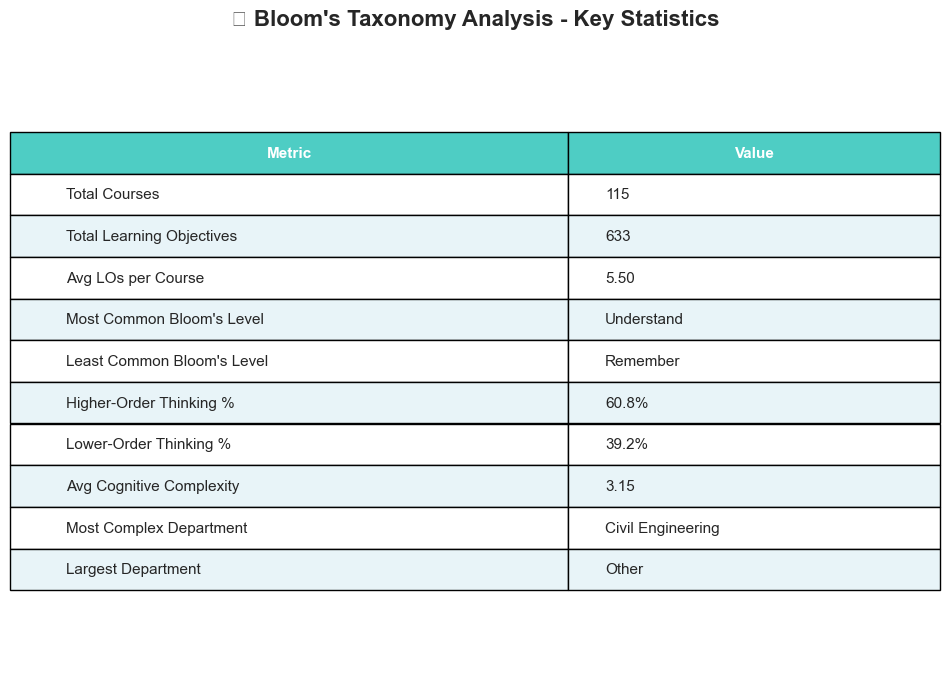


🔍 KEY INSIGHTS FROM BLOOM'S TAXONOMY ANALYSIS

1️⃣ OVERALL STATISTICS:
   • Total Courses Analyzed: 115
   • Total Learning Objectives: 633
   • Average LOs per Course: 5.50

2️⃣ BLOOM'S LEVEL DISTRIBUTION:
   • Remember: 20 (3.2%)
   • Understand: 228 (36.0%)
   • Apply: 196 (31.0%)
   • Analyze: 84 (13.3%)
   • Evaluate: 35 (5.5%)
   • Create: 70 (11.1%)

3️⃣ COGNITIVE COMPLEXITY:
   • Average Complexity Score: 3.15 / 6.0
   • Higher-Order Thinking: 385 LOs (60.8%)
   • Lower-Order Thinking: 248 LOs (39.2%)

4️⃣ TOP 5 MOST COMPLEX COURSES:
   1. Principles of Programming Languages (PoPL)... (Avg: 4.80)
   2. VLSI Design... (Avg: 4.67)
   3. Introduction to Neural and Cognitive Modeling... (Avg: 4.50)
   4. Intro to Cognitive Science... (Avg: 4.40)
   5. Data Analytics-I... (Avg: 4.40)

5️⃣ DEPARTMENT INSIGHTS:
   1. Other: 230 LOs (Avg Complexity: 3.08)
   2. Computer Science & Engineering: 100 LOs (Avg Complexity: 3.39)
   3. Design & Innovation: 64 LOs (Avg Complexity: 3.09)
   4.

In [14]:
# Create comprehensive summary
summary_stats = {
    'Total Courses': df['course'].nunique(),
    'Total Learning Objectives': len(df),
    'Avg LOs per Course': f"{los_per_course.mean():.2f}",
    'Most Common Bloom\'s Level': level_counts.index[0],
    'Least Common Bloom\'s Level': level_counts.index[-1],
    'Higher-Order Thinking %': f"{(category_counts.get('Higher-Order Thinking', 0)/len(df)*100):.1f}%",
    'Lower-Order Thinking %': f"{(category_counts.get('Lower-Order Thinking', 0)/len(df)*100):.1f}%",
    'Avg Cognitive Complexity': f"{df['complexity'].mean():.2f}",
    'Most Complex Department': dept_complexity.index[0],
    'Largest Department': dept_counts.index[0]
}

# Create visualization
fig, ax = plt.subplots(figsize=(12, 8))
ax.axis('tight')
ax.axis('off')

summary_table = list(summary_stats.items())
table = ax.table(cellText=summary_table, colLabels=['Metric', 'Value'],
                cellLoc='left', loc='center',
                colWidths=[0.6, 0.4])

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

# Style the header
for i in range(2):
    table[(0, i)].set_facecolor('#4ECDC4')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Alternate row colors
for i in range(1, len(summary_table) + 1):
    if i % 2 == 0:
        table[(i, 0)].set_facecolor('#E8F4F8')
        table[(i, 1)].set_facecolor('#E8F4F8')

plt.title('📊 Bloom\'s Taxonomy Analysis - Key Statistics', 
          fontsize=16, fontweight='bold', pad=20)
plt.show()

# Print detailed insights
print("\n" + "="*70)
print("🔍 KEY INSIGHTS FROM BLOOM'S TAXONOMY ANALYSIS")
print("="*70)

print(f"\n1️⃣ OVERALL STATISTICS:")
print(f"   • Total Courses Analyzed: {df['course'].nunique()}")
print(f"   • Total Learning Objectives: {len(df)}")
print(f"   • Average LOs per Course: {los_per_course.mean():.2f}")

print(f"\n2️⃣ BLOOM'S LEVEL DISTRIBUTION:")
for level in bloom_order:
    count = level_counts.get(level, 0)
    pct = (count / len(df) * 100) if len(df) > 0 else 0
    print(f"   • {level}: {count} ({pct:.1f}%)")

print(f"\n3️⃣ COGNITIVE COMPLEXITY:")
print(f"   • Average Complexity Score: {df['complexity'].mean():.2f} / 6.0")
print(f"   • Higher-Order Thinking: {category_counts.get('Higher-Order Thinking', 0)} LOs ({category_counts.get('Higher-Order Thinking', 0)/len(df)*100:.1f}%)")
print(f"   • Lower-Order Thinking: {category_counts.get('Lower-Order Thinking', 0)} LOs ({category_counts.get('Lower-Order Thinking', 0)/len(df)*100:.1f}%)")

print(f"\n4️⃣ TOP 5 MOST COMPLEX COURSES:")
for i, (course, complexity) in enumerate(course_complexity.head(5).items(), 1):
    print(f"   {i}. {course[:60]}... (Avg: {complexity:.2f})")

print(f"\n5️⃣ DEPARTMENT INSIGHTS:")
for i, (dept, count) in enumerate(dept_counts.head(5).items(), 1):
    complexity = dept_complexity[dept]
    print(f"   {i}. {dept}: {count} LOs (Avg Complexity: {complexity:.2f})")

print("\n" + "="*70)

## 9. Export Summary to CSV (Optional)

In [15]:
# Export the processed data to CSV for further analysis
df.to_csv('../datasets/blooms_taxonomy_analysis.csv', index=False, encoding='utf-8')
print("✅ Data exported to: ../datasets/blooms_taxonomy_analysis.csv")

# Export course-level summary
course_summary = df.groupby('course').agg({
    'level': lambda x: x.value_counts().to_dict(),
    'complexity': 'mean',
    'cognitive_category': lambda x: (x == 'Higher-Order Thinking').sum()
}).rename(columns={'cognitive_category': 'higher_order_count'})

course_summary['total_los'] = df.groupby('course').size()
course_summary['avg_complexity'] = course_summary['complexity'].round(2)
course_summary.to_csv('../datasets/course_level_summary.csv', encoding='utf-8')
print("✅ Course summary exported to: ../datasets/course_level_summary.csv")

print("\n📁 Files created:")
print("   1. blooms_taxonomy_analysis.csv - Detailed LO-level data")
print("   2. course_level_summary.csv - Aggregated course-level statistics")

✅ Data exported to: ../datasets/blooms_taxonomy_analysis.csv
✅ Course summary exported to: ../datasets/course_level_summary.csv

📁 Files created:
   1. blooms_taxonomy_analysis.csv - Detailed LO-level data
   2. course_level_summary.csv - Aggregated course-level statistics
